In [8]:
import h5py
import numpy as np
from scipy.signal import sosfiltfilt, butter
import matplotlib.pyplot as plt
import copy

In [2]:
filename = r"../data/offline_tests/session_25__set_1.h5"
with h5py.File(filename, "r") as h5f:
    print(h5f['data'].keys())
    eeg = h5f['data/EEG_f'][:]
    emg = h5f['data/EMG_f'][:]
    trigger = h5f['data/TRIG'][:]
eeg.shape, emg.shape, trigger.shape

<KeysViewHDF5 ['EEG_f', 'EMG_f', 'TRIG', 'TRIGGER']>


((2308416, 64), (2308416, 1), (11542080, 1))

In [4]:
factor = 5
trigger_resample = trigger[::factor]
data = np.concatenate([eeg, emg, trigger_resample], axis=1)

In [7]:
74078484.0 - 74078369.0

115.0

In [9]:
Fs = 25000 # Hz
start_idx, end_idx = 150000, 170000
ch = 10

In [10]:
factor = 5
trigger_resample = trigger[::factor]

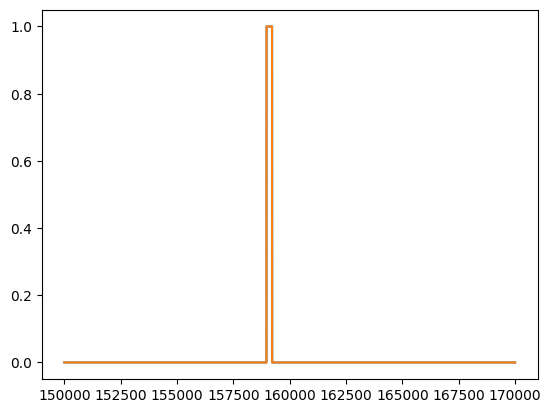

In [15]:
time = np.arange(len(trigger))
new_time  = np.arange(0, len(trigger), factor)
plt.plot(time[start_idx:end_idx], trigger[start_idx:end_idx]);
plt.plot(new_time[start_idx//factor:end_idx//factor], trigger_resample[start_idx//factor:end_idx//factor]);

In [4]:
filename = r"../data/offline_tests/01_AV_M1_qp_45.hdf5"
with h5py.File(filename, "r") as h5f:
    print(h5f["eeg"].keys())
    data = h5f["eeg/data"][:-1]
data.shape

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../data/offline_tests/01_AV_M1_qp_45.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [39]:
bit = 0
ttl = np.array(data[:, -1], dtype=np.uint8)
trigger = ((ttl>>bit) & 0b1).astype(int)

In [ ]:
def find_events(trigger, up_front=True):
    """
    trigger: ndarray(int) - 0 or 1
    up_front: True if (event == from 0 to 1) else False 
    """
    trigger_d = np.diff(trigger)  # 1 if 0 -> 1; -1 if 1 -> 0
    target = 1 if up_front else -1
    return np.where(trigger_d == target)[0]

events = find_events(trigger, up_front=False)       # from 1 to 0 

In [ ]:
signal = np.array(data[:, :-1], dtype=np.float32)

In [137]:
art_start_ms, art_end_ms = -0.04, 0.85
ms_to_sample = lambda ms: int(ms * Fs / 1000)
def interp_signal(signal, events, art_start, art_end):
    length = art_end - art_start
    ch = signal.shape[1]
    for event in events:
        before_sample = signal[event+art_start-1].reshape((-1, 1))
        after_sample = signal[event+art_end+1].reshape((-1, 1))
        new_value = np.concatenate([before_sample, after_sample], axis=1).mean(axis=1)
        interp_interval = np.array([np.full((length), interp_value) for interp_value in new_value]).T
        signal[event+art_start:event+art_end, :] = interp_interval
    return signal

signal_interp = interp_signal(copy.copy(signal), events, ms_to_sample(art_start_ms), ms_to_sample(art_end_ms))

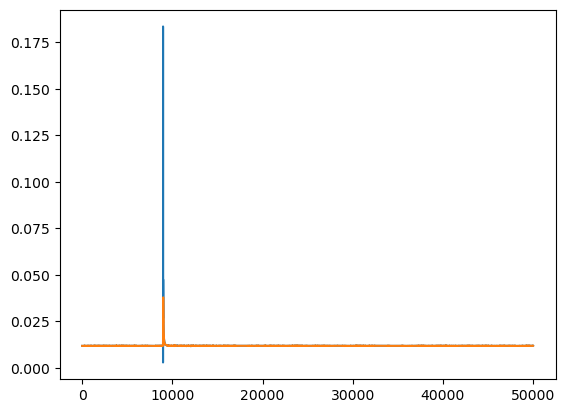

In [140]:
plt.plot(signal[start_idx:end_idx, ch]);
plt.plot(signal_interp[start_idx:end_idx, ch]);

In [ ]:

high_freq = 2500 
sos = butter(N=4, Wn=high_freq, btype="highpass", output='sos', fs=Fs)
data_filt = sosfiltfilt(np.ascontiguousarray(sos), signal)

In [ ]:
factor = 5
data_down = data_filt[::factor]
trigger_

In [4]:
import h5py
filename = r'C:\Users\hodor\Documents\lab-MSU\Works\signal_simulator_player\resourcers\AV_75triplets_5kHz.h5'
with h5py.File(filename, "r") as h5f:
    print(h5f.keys())
    data = h5f['data'][:]

<KeysViewHDF5 ['data']>


In [105]:
emg = np.diff(data[:, 64:66], axis=1)
freqs = [20, 1000] 
Fs = 5000
sos = butter(N=4, Wn=freqs, btype="bandpass", output='sos', fs=Fs)
emg_ff = sosfiltfilt(np.ascontiguousarray(sos), emg.reshape((1, -1)))

# Q = 50 / 1
# from scipy.signal import iirnotch, tf2sos
# b_notch, a_notch = iirnotch(50, Q, fs=Fs)
# sos_notch = tf2sos(b_notch, a_notch)
# emg_ff = sosfiltfilt(sos_notch, emg_f, axis=1)
# # emg_f = emg

In [106]:
emg_ff = emg_ff.reshape((-1, 1))
emg_ff

array([[ 1.59452420e-06],
       [-3.16532203e-06],
       [-4.69778955e-06],
       ...,
       [ 6.01810550e-06],
       [ 2.67769704e-06],
       [-1.96974118e-06]], shape=(1000000, 1))

In [107]:
ttl = np.array(data[:, -1], dtype=np.uint8)
trigger = ((ttl>>0) & 0b1).astype(int)

(-0.2, 0.3)

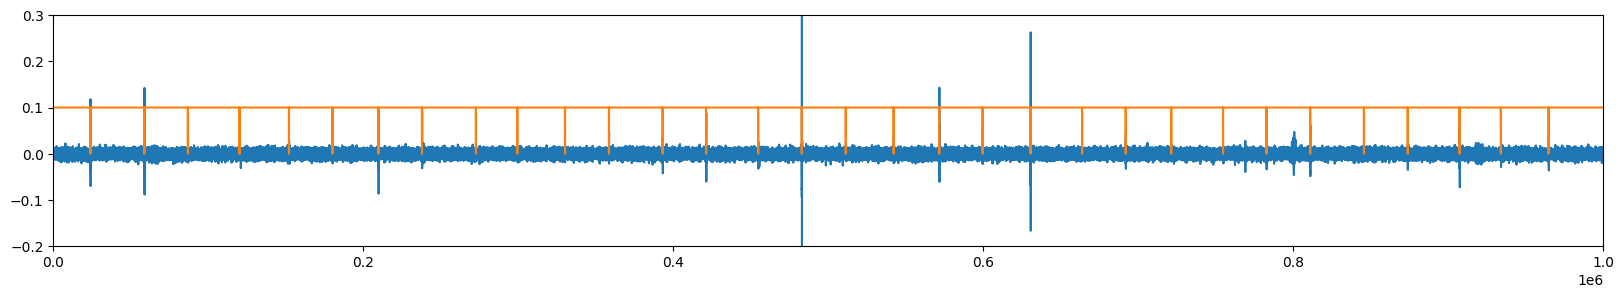

In [110]:
plt.figure(figsize=(20, 3))
plt.plot(emg_ff*1E3)
plt.plot(trigger*1e-1)
plt.xlim(0, 1E6)
plt.ylim(-0.2, 0.3)

In [111]:
from scipy.signal import welch

freqs, power = welch(emg_ff.reshape((1, -1)), fs=Fs, nperseg=512)

In [98]:
freqs.shape, power.shape

((257,), (1, 257))

(20.0, 450.0)

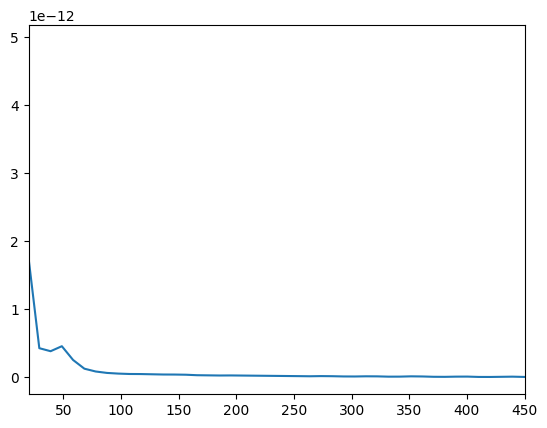

In [104]:
plt.plot(freqs, power.reshape((-1, 1)))
plt.xlim(20, 450)